In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
import src.config
import src.data
import src.model_new
import src.utils
from src.model_new import (
    T5EncoderModelForTokenClassification,
)

import gc
import copy
import random

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import src.utils

from transformers import (
    T5Tokenizer,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback
)

import peft
from peft import (
    LoraConfig,
)

In [31]:
ROOT = src.utils.get_project_root_path()
device = torch.device('cuda:0' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

USE_CRF = True

EXPERT = 'LIPO'
MODEL_VERRSION = src.config.model_version

adapter_location = f'/models/moe_v1_expert_{EXPERT}_{MODEL_VERRSION}'

SEED = 42
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

print("Base Model:\t", src.config.base_model_name)
print("MPS:\t\t", torch.backends.mps.is_available())
print("Path:\t\t", ROOT)
print(f"Using device:\t {device}")

Base Model:	 Rostlab/prot_t5_xl_uniref50
MPS:		 False
Path:		 /home/ec2-user/developer/prottrans-t5-signalpeptide-prediction
Using device:	 cuda:0


In [ ]:
t5_tokenizer = T5Tokenizer.from_pretrained(
    pretrained_model_name_or_path=src.config.base_model_name,
    do_lower_case=False,
    use_fast=True,
    legacy=False
)

In [ ]:
FASTA_FILENAME = '5_SignalP_5.0_Training_set.fasta'
# FASTA_FILENAME = '5_SignalP_5.0_Training_set_testing.fasta'
annotations_name = 'Label' # Choose Type or Label

df_data = src.data.process(src.data.parse_file(ROOT + '/data/raw/' + FASTA_FILENAME))

dataset_signalp_type_splits = {}

dataset_signalp_type_splits.update(
    {'ALL': src.model_new.create_datasets(
        splits=src.config.splits,
        tokenizer=t5_tokenizer,
        data=df_data,
        annotations_name=annotations_name,
        dataset_size=src.config.dataset_size,
        encoder=src.config.label_encoding,
    )})

for sequence_type in src.config.type_encoding.keys():
    dataset_signalp = src.model_new.create_datasets(
        splits=src.config.splits,
        tokenizer=t5_tokenizer,
        data=df_data,
        annotations_name=annotations_name,
        dataset_size=src.config.dataset_size,
        encoder=src.config.select_encoding_type[sequence_type],
        sequence_type=sequence_type
        )
    dataset_signalp_type_splits.update({sequence_type: dataset_signalp})

del df_data

In [ ]:
dataset_signalp = dataset_signalp_type_splits[EXPERT]
display(dataset_signalp)

In [ ]:
# for x in range(3):
#     print(len(dataset_signalp['valid'][x]['labels']))
#     print(*dataset_signalp['valid'][x]['labels'])

In [ ]:
t5_base_model = T5EncoderModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=src.config.base_model_name,
    device_map='auto',
    load_in_8bit=False,
    custom_num_labels=len(src.config.select_decoding_type[EXPERT]),
    custom_dropout_rate=0.1,
    use_crf=USE_CRF,
)

tmp_lin = nn.Linear(
    in_features=t5_base_model.config.hidden_size,
    out_features=t5_base_model.custom_num_labels
)
t5_base_model.custom_classifier.weight = tmp_lin.weight
t5_base_model.custom_classifier.bias = tmp_lin.bias

if USE_CRF:
    t5_base_model.crf.reset_parameters()
    
if USE_CRF:
    modules_to_save = ['custom_classifier', 'crf']
else:
    modules_to_save = ['custom_classifier']

lora_config = LoraConfig(
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=['q', 'k', 'v', 'o'],
    bias="none",
    modules_to_save=modules_to_save,
)

t5_lora_model = peft.get_peft_model(t5_base_model, lora_config)
t5_lora_model.print_trainable_parameters()

In [ ]:
# print([x for x in t5_lora_model.custom_classifier.modules_to_save.default.named_parameters()])
# print(t5_lora_model.custom_classifier.modules_to_save.default.weight.mean())
# print(t5_lora_model.custom_classifier.modules_to_save.default.bias.mean())

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer=t5_tokenizer)

training_args = TrainingArguments(
    output_dir='./checkpoints',
    learning_rate=src.config.lr,
    per_device_train_batch_size=src.config.batch_size,
    per_device_eval_batch_size=src.config.batch_size,
    num_train_epochs=src.config.num_epochs,
    logging_steps=src.config.logging_steps,
    # save_strategy="steps",
    # save_steps=src.config.save_steps,
    evaluation_strategy="steps",
    eval_steps=src.config.eval_steps,
    # gradient_accumulation_steps=accum,
    # load_best_model_at_end=True,
    # save_total_limit=5,
    seed=42,
    # fp16=True,
    # deepspeed=deepspeed_config,
    remove_unused_columns=False,
    label_names=['labels'],
    # debug="underflow_overflow",
)

trainer = Trainer(
    model=t5_lora_model,
    args=training_args,
    train_dataset=dataset_signalp['train'],
    eval_dataset=dataset_signalp['valid'],
    data_collator=data_collator,
    compute_metrics=src.model_new.compute_metrics,
)

In [ ]:
initial_validation=trainer.evaluate()
added_initial_validation = False
print(initial_validation)

In [ ]:
gc.collect()
torch.cuda.empty_cache()
# torch.mps.empty_cache()

trainer.train()

In [ ]:
final_validation=trainer.evaluate()
print(final_validation)

In [ ]:
if 'training_log' not in locals():
    training_log = pd.DataFrame(trainer.state.log_history)
else:
    training_log = pd.concat([training_log, pd.DataFrame(trainer.state.log_history)], ignore_index=True)
if not added_initial_validation:
    added_initial_validation = True
    training_log = pd.concat([pd.DataFrame([initial_validation]), training_log], ignore_index=True)
display(training_log)

In [ ]:
if 'eval_confusion_matrix' in training_log.columns:
    training_log['eval_confusion_matrix'] = training_log['eval_confusion_matrix'].apply(lambda x: x.tolist() if type(x)==np.ndarray else None)
t5_lora_model.save_pretrained(ROOT + adapter_location)
training_log.to_csv(ROOT + adapter_location + '/training_log.csv', index=False)
training_log.to_parquet(ROOT + adapter_location + '/training_log.parquet')

In [36]:
ROOT + adapter_location + 'cm.jpg'

'/home/ec2-user/developer/prottrans-t5-signalpeptide-prediction/models/moe_v1_expert_LIPO_1cm.jpg'

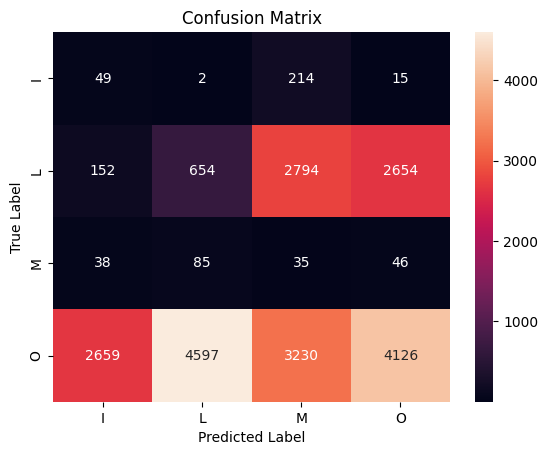

In [35]:
src.model_new.confusion_matrix_plot(
    np.array(training_log['eval_confusion_matrix'][training_log['eval_confusion_matrix'].notnull()].iloc[0].tolist()),
    src.config.select_decoding_type[EXPERT]
    )
plt.savefig(ROOT + adapter_location + 'cm.jpg')

In [7]:
training_log = pd.read_parquet(ROOT + f'/models/moe_v1_expert_{EXPERT}_{MODEL_VERRSION}/training_log.parquet')

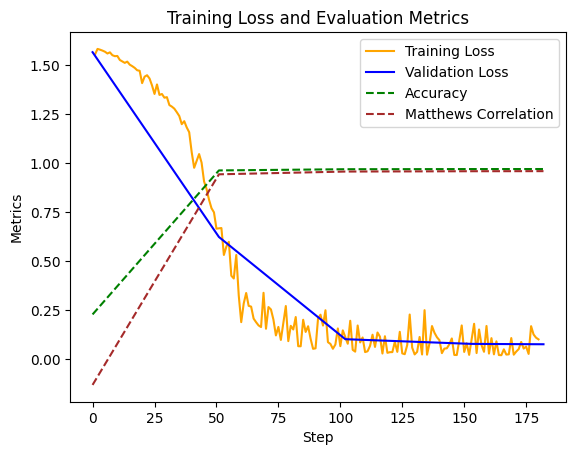

In [19]:
result = src.model_new.validation_evaluation_plots(training_log, src.config.select_decoding_type[EXPERT])

In [16]:
result.show()

---

In [ ]:
# [x for x in t5_lora_model.custom_classifier.modules_to_save.default.named_parameters()]

In [ ]:
# display(pd.Series([item for row in dataset_signalp['train']['labels'] for item in row]).value_counts())
# display(pd.Series([item for row in dataset_signalp['valid']['labels'] for item in row]).value_counts())
# display(pd.Series([item for row in dataset_signalp['test']['labels'] for item in row]).value_counts())

# src.model_new.make_confusion_matrix(
#     training_log['eval_confusion_matrix'].iloc[-1],
#     src.config.select_decoding_type[EXPERT])

In [ ]:
# _ds_index = 3250
_ds_index = 3250
_ds_type = 'test'
USE_CRF = False

_input_ids_test = t5_tokenizer.decode(dataset_signalp[_ds_type][_ds_index]['input_ids'][:-1])
_labels_test = torch.tensor([dataset_signalp[_ds_type][_ds_index]['labels'] + [-100]]).to(device)
_attention_mask_test = torch.tensor([dataset_signalp[_ds_type][_ds_index]['attention_mask']]).to(device)

_labels_test_decoded = [src.config.label_decoding[x] for x in _labels_test.tolist()[0][:-1]]

print('Iput IDs:\t', _input_ids_test)
print('Labels:\t\t', *_labels_test.tolist()[0])
print('Labels Decoded:\t', *_labels_test_decoded)
print('Attention Mask:\t', *_attention_mask_test.tolist()[0])
print('----')

preds = src.model_new.predict_model(
    sequence=_input_ids_test,
    tokenizer=t5_tokenizer,
    model=t5_lora_model,
    labels=_labels_test,
    attention_mask=_attention_mask_test,
    device=device,
    viterbi_decoding=USE_CRF,
    )

_result = src.model_new.translate_logits(
    logits=preds.logits,
    viterbi_decoding=USE_CRF,
    decoding=src.config.label_decoding
    )

print('Result: \t',* _result)